In [2]:
from __future__ import annotations
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os, sys

# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
code_root = os.path.join(ipynb_dir, '..')
sys.path.append(code_root)  # Needed for import below

from sc2sensor.dataset import StarCraftSensor
from sc2sensor.utils.unit_type_data import NONNEUTRAL_CHANNEL_TO_ID, NONNEUTRAL_ID_TO_NAME
CHANNEL_TO_NAME = [NONNEUTRAL_ID_TO_NAME[NONNEUTRAL_CHANNEL_TO_ID[i]] for i in range(len(NONNEUTRAL_CHANNEL_TO_ID))]

data_root = os.path.join(code_root, 'data') # Data root directory
data_subdir = 'starcraft-sensor-dataset'

In [3]:
# Create subclass of original dataset for next window prediction
class NextWindowDataset(StarCraftSensor):
  def __init__(self, *args, max_samples=None, **kwargs):
    assert 'use_sparse' not in kwargs, 'Cannot set use_sparse with this dataset.'
    assert 'compute_labels' not in kwargs, 'Cannot set use_sparse with this dataset.'
    super().__init__(*args, use_sparse=True, compute_labels=False, **kwargs)
    self.max_samples = max_samples
    
    # Sort data so that next index is merely + 1
    self.metadata = self.metadata.sort_values(['static.replay_name', 'dynamic.window_idx']).reset_index(drop=True)
    md = self.metadata
    
    # Get starting window indices
    start_windows = md[(md['dynamic.num_windows'] > 1) 
                       & (md['dynamic.window_idx'] < (md['dynamic.num_windows'] - 1))]
    self.start_idx = start_windows.index

  def __getitem__(self, idx):
    # Get original indices of start and end based on input 
    md = self.metadata
    # Assumes sorted
    orig_idx = self.start_idx[idx]
    next_idx = orig_idx + 1
    # Only sanity check first and last as this may be expensive
    if idx == 0 or idx == len(self) - 1:
      assert md['static.replay_name'][orig_idx] == md['static.replay_name'][next_idx], 'Replays are not the same'
      assert md['dynamic.window_idx'][orig_idx] + 1 == md['dynamic.window_idx'][next_idx], 'Window indices are not adjacent'

    # Get combined hyperspectral images
    def get_hyperspectral_dense(idx):
      # Concatenate player1 and player2 hyperspectral
      replay_file, window_idx = self._get_replay_and_window_idx(idx)
      with np.load(replay_file) as data:
        player_1_hyperspectral = self._extract_hyperspectral(
          'player_1', data, window_idx)
        player_2_hyperspectral = self._extract_hyperspectral(
          'player_2', data, window_idx)
      return torch.concat([player_1_hyperspectral.to_dense(), 
                           player_2_hyperspectral.to_dense()], 
                          dim=-3).float()
    windows = [get_hyperspectral_dense(idx) for idx in [orig_idx, next_idx]] 
    x = windows[0]
    y = windows[1] - windows[0] # Compute diff
    return x, y

  def __len__(self):
    if self.max_samples is not None:
      return min(self.max_samples, len(self.start_idx))
    else:
      return len(self.start_idx)

In [4]:
# Load datasets
max_samples = 10000
next_window_train = NextWindowDataset(root=data_root, subdir=data_subdir, train=True, max_samples=max_samples)

single = next_window_train[-1]
n_input_channels = single[0].shape[0]  # Needed for preprocessor to get down to 3 channels
print(f'Num train: {len(next_window_train)}') #, Num test: {len(next_window_test)}')
#print(f'Num train: {len(next_window_train)}, Num test: {len(next_window_test)}')
print(f'x.shape: {single[0].shape}, y.shape: {single[1].shape}')

Using cached CSV metadata
Not computing labels
Post-processing metadata
Finished dataset init
Num train: 10000
x.shape: torch.Size([340, 64, 64]), y.shape: torch.Size([340, 64, 64])


In [5]:
from sc2sensor.utils.sensor_utils import SensorPlacementDataset, SUPPORTED_PLACEMENT_KINDS as PLACEMENT_KINDS

Notice that first 3 are the same (i.e., in the same match) while the last 3 are different


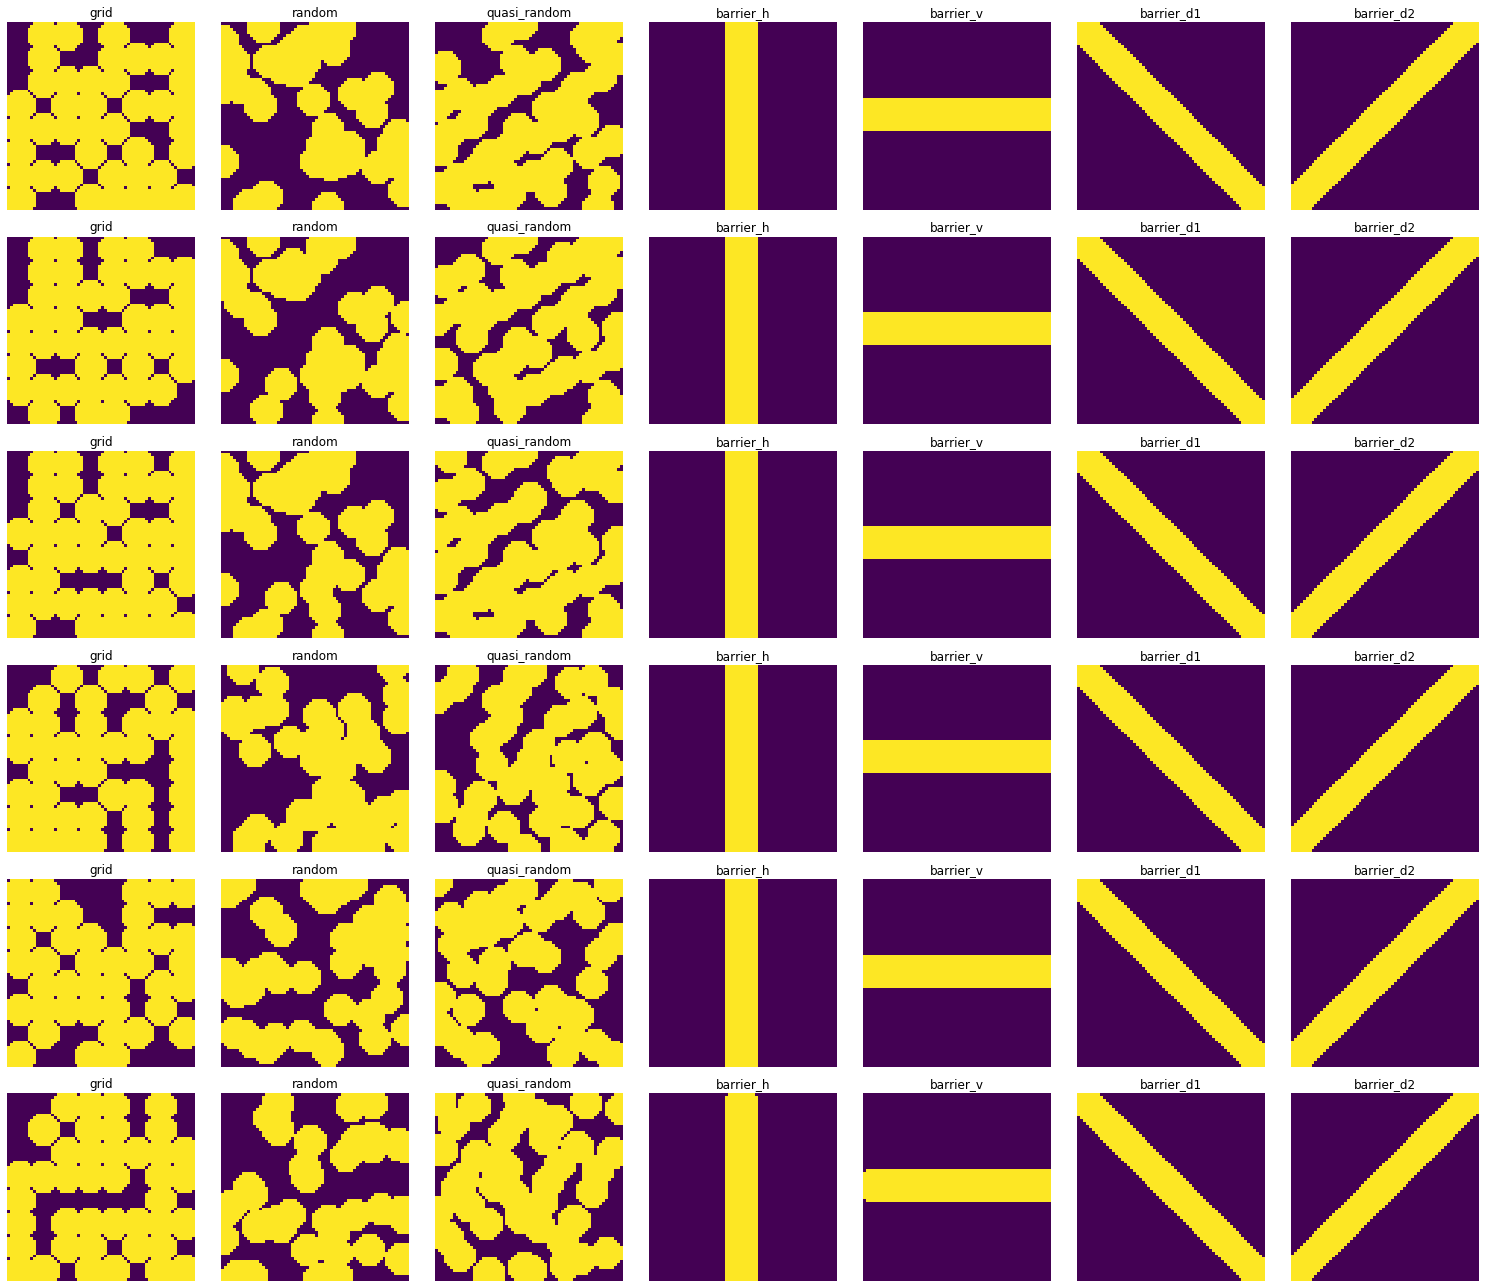

In [22]:
show_idx = [0, 1, 2, 100, 200, 300]
nr, nc = len(show_idx), len(PLACEMENT_KINDS)
fig, axes_mat = plt.subplots(nr, nc, figsize=[nc*3, nr*3])
axes_mat = axes_mat.reshape((nr, nc)) # Ensure 2D
for kind, axes in zip(PLACEMENT_KINDS, axes_mat.T):
  sp_dataset = SensorPlacementDataset(
    next_window_train, n_sensors=50, radius=5.5, 
    kind=kind, failure_rate=0.2, return_mask=True)
  for idx, ax in zip(show_idx, axes):
    ax.imshow(sp_dataset[idx][2])
    ax.axis('off')
    ax.set_title(f'{kind}')
    if kind == PLACEMENT_KINDS[0]:
      ax.set_ylabel(f'Sample {idx}')
fig.tight_layout()
print('Notice that first 3 are the same (i.e., in the same match) while the last 3 are different')

In [23]:
# approximating sensor coverage
sensor_radius = 5.5
n_sensors = 50 
coverage_per_sensor = np.pi*sensor_radius**2 / (64**2)
print(f'Trying radius: {sensor_radius} with {n_sensors} sensors ',
      f'(where each sensor covers {coverage_per_sensor:.1%} of the map)')
#for kind in PLACEMENT_KINDS[::-1]:
for kind in PLACEMENT_KINDS[::-1]:
    sp_dataset = SensorPlacementDataset(
        next_window_train, n_sensors=n_sensors, radius=sensor_radius, 
        kind=kind, failure_rate=0, return_mask=True)

    coverages = []
    for i in np.random.choice(len(sp_dataset), size=100):
        coverages.append(sp_dataset[i][-1].sum() / sp_dataset[i][-1].numel())
    print(f'{kind} coverage: {np.mean(coverages):%}')



Trying radius: 5.5 with 50 sensors  (where each sensor covers 2.3% of the map)
barrier_d2 coverage: 22.045898%
barrier_d1 coverage: 22.070312%
barrier_v coverage: 17.187500%
barrier_h coverage: 17.187500%
quasi_random coverage: 80.301756%
random coverage: 66.399658%
grid coverage: 85.057372%


# Generating Examples from Datasets

In [70]:
def generate_sensor_comparison_plots(oracle_dataset, sensor_parameters,
                                     seed=None, save_name=None):
    
    def check_channels(image):
        if image.shape[0] == 340:
            return image.sum(0)
        else:
            return image
    
    types = ['oracle', *PLACEMENT_KINDS]
    
    fig, axes = plt.subplots(2, len(types), figsize=(20, 10))
    
    
    for type_idx, sensor_type in enumerate(types):
        rng = np.random.RandomState(42 if seed is None else seed)
        if sensor_type == 'oracle':
            dataset = oracle_dataset
        else:
            sensor_parameters['kind'] = sensor_type
            dataset = SensorPlacementDataset(
                oracle_dataset, **sensor_parameters,
                return_mask=False, make_cache=False, noiseless_ground_truth=False)
        for sample_plot_idx, sample_idx in enumerate(rng.choice(len(dataset), size=1)):
            
            sample_x, sample_y = dataset[sample_idx]
            
            axes[0, type_idx].imshow(check_channels(sample_x))
            axes[0, type_idx].set_title(f'{sensor_type} input', fontsize=18)
            
            axes[1, type_idx].imshow(check_channels(sample_y))
            axes[1, type_idx].set_title(f'{sensor_type} labels', fontsize=18)
    for ax in axes.flatten():
        ax.axis('off')
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    return None

In [50]:
data_root = os.path.join(code_root, 'data') # Data root directory
data_subdir = 'starcraft-sensor-dataset'

sensor_kwargs = {'n_sensors': 50,
                 'radius': 5.5,
                 'kind': 'grid',
                 'failure_rate': 0.2}

# Generating Unit ID Examples:

In [51]:
import os, sys
# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
code_root = os.path.join(ipynb_dir, '..')
sys.path.append(code_root)  # Needed for import below

from sc2sensor.dataset import StarCraftSensor
from sc2sensor.utils.sensor_utils import SensorPlacementDataset, SUPPORTED_PLACEMENT_KINDS
from sc2sensor.utils.unit_type_data import NONNEUTRAL_CHANNEL_TO_ID, NONNEUTRAL_ID_TO_NAME
CHANNEL_TO_NAME = [NONNEUTRAL_ID_TO_NAME[NONNEUTRAL_CHANNEL_TO_ID[i]] for i in range(len(NONNEUTRAL_CHANNEL_TO_ID))]
# removing barrier_h and barrier_v from the placement kinds since diag kinds are more fitting
PLACEMENT_KINDS = [kind for kind in SUPPORTED_PLACEMENT_KINDS if not (kind.endswith('_h') or kind.endswith('_v'))]


from sc2sensor.utils.unit_type_data import NONNEUTRAL_CHANNEL_TO_ID, NONNEUTRAL_ID_TO_NAME
CHANNEL_TO_NAME = [NONNEUTRAL_ID_TO_NAME[NONNEUTRAL_CHANNEL_TO_ID[i]] for i in range(len(NONNEUTRAL_CHANNEL_TO_ID))]

from fastai.data.all import Transform, DataBlock, RandomSplitter, L
from fastai.vision.all import *
from fastai.distributed import *
from fastai.callback.all import SaveModelCallback, EarlyStoppingCallback
import segmentation_models_pytorch as smp

In [52]:
# Loading dataset
class SegmentationDataset(torch.utils.data.Dataset):
    
    def __init__(self, segment_path, create_metadata=True):
        super().__init__()
        self.path = Path(segment_path)
        self.X_filenames = self._get_files()
        if create_metadata:
            self.metadata, self.match_metadata = self._make_metadata()
        
    def __len__(self):
        return len(self.X_filenames)
    
    def __getitem__(self, idx):
        X_filename = self.X_filenames[idx]
        y_filename = os.path.splitext(X_filename)[0].replace('images','labels') + '_labels.png'
        
#         return torch_read_image(str(X_filename)), torch_read_image(str(y_filename)).squeeze()
        return (plt.imread(str(X_filename))*255).astype(np.uint8), \
               (plt.imread(str(y_filename))*255).astype(np.uint8)

    def _get_files(self):
        files =  list((self.path / 'images').glob('**/*.png'))
        assert len(files) > 0, f'No .png files found in {self.path}'
        return files
    
    def _make_metadata(self):
        replay_names = [str(f).split('_')[-2].split('/')[-1] for f in self.X_filenames]
        metadata = pd.DataFrame({'static.replay_name':replay_names})
        match_metadata = metadata.drop_duplicates(subset=['static.replay_name']).reset_index(drop=True)
        return metadata, match_metadata

In [53]:
segmentation_data_path = Path(data_root)/'starcraft-sensor-dataset'/'segment'/'test'

In [54]:
segmentation_dataset = SegmentationDataset(segmentation_data_path,
                                           create_metadata=True)

segmentation_sensor_placement_dataset = SensorPlacementDataset(
        segmentation_dataset, **sensor_kwargs,
        return_mask=False, make_cache=False, noiseless_ground_truth=True)

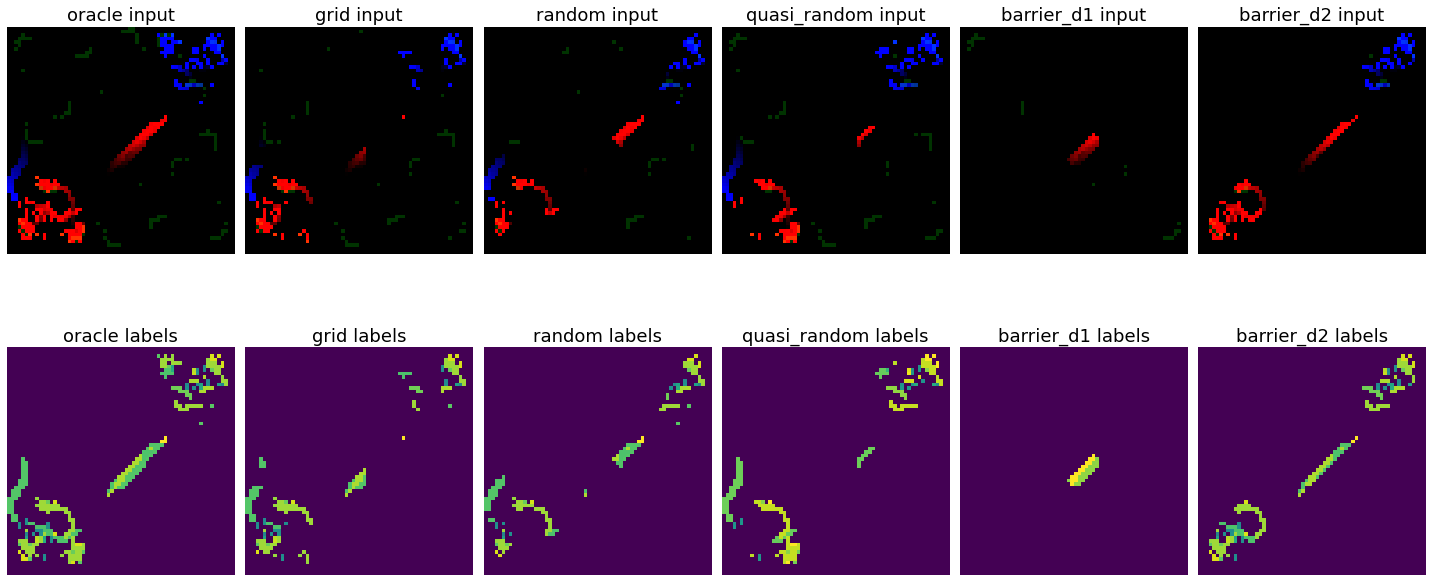

In [73]:
generate_sensor_comparison_plots(segmentation_dataset, sensor_kwargs, seed=15, save_name='Unit-ID-Sensor-Plots.pdf')

# Generating Next Window Examples

In [56]:
# Create subclass of original dataset for next window prediction
class NextWindowDataset(StarCraftSensor):
  def __init__(self, *args, max_samples=None, **kwargs):
    assert 'use_sparse' not in kwargs, 'Cannot set use_sparse with this dataset.'
    assert 'compute_labels' not in kwargs, 'Cannot set use_sparse with this dataset.'
    super().__init__(*args, use_sparse=True, compute_labels=False, **kwargs)
    self.max_samples = max_samples
    
    # Sort data so that next index is merely + 1
    self.metadata = self.metadata.sort_values(['static.replay_name', 'dynamic.window_idx']).reset_index(drop=True)
    md = self.metadata
    
    # Get starting window indices
    start_windows = md[(md['dynamic.num_windows'] > 1) 
                       & (md['dynamic.window_idx'] < (md['dynamic.num_windows'] - 1))]
    self.start_idx = start_windows.index

  def __getitem__(self, idx):
    # Get original indices of start and end based on input 
    md = self.metadata
    # Assumes sorted
    orig_idx = self.start_idx[idx]
    next_idx = orig_idx + 1
    # Only sanity check first and last as this may be expensive
    if idx == 0 or idx == len(self) - 1:
      assert md['static.replay_name'][orig_idx] == md['static.replay_name'][next_idx], 'Replays are not the same'
      assert md['dynamic.window_idx'][orig_idx] + 1 == md['dynamic.window_idx'][next_idx], 'Window indices are not adjacent'

    # Get combined hyperspectral images
    def get_hyperspectral_dense(idx):
      # Concatenate player1 and player2 hyperspectral
      replay_file, window_idx = self._get_replay_and_window_idx(idx)
      with np.load(replay_file) as data:
        player_1_hyperspectral = self._extract_hyperspectral(
          'player_1', data, window_idx)
        player_2_hyperspectral = self._extract_hyperspectral(
          'player_2', data, window_idx)
      return torch.concat([player_1_hyperspectral.to_dense(), 
                           player_2_hyperspectral.to_dense()], 
                          dim=-3).float()
    windows = [get_hyperspectral_dense(idx) for idx in [orig_idx, next_idx]] 
    x = windows[0]
    y = windows[1] - windows[0] # Compute diff
    return x, y

  def __len__(self):
    if self.max_samples is not None:
      return min(self.max_samples, len(self.start_idx))
    else:
      return len(self.start_idx)

# Create fastai dataloaders given the PyTorch dataset
class AddChannelCodes(Transform):
  "Add the code metadata to a `TensorMask`"
  def __init__(self, codes=None):
      self.codes = codes
      if codes is not None: self.vocab,self.c = codes,len(codes)

  def decodes(self, o):
      if self.codes is not None: o.codes=self.codes
      return o
    
# HACK: Put all instances in both "train" and "valid"
# From https://forums.fast.ai/t/solved-not-splitting-datablock/84759/3
def all_splitter(o): return L(int(i) for i in range(len(o))), L(int(i) for i in range(len(o)))
    
SC2_CODES = [
  f'{player}_{name}'
  for player in ['P1','P2']
  for name in CHANNEL_TO_NAME
]
def create_dataloaders_from_dataset(dataset, splitter=None, **kwargs):
    # Needs to have reference to dataset for closures
    assert 'get_x' not in kwargs
    assert 'get_y' not in kwargs
    assert 'get_items' not in kwargs
    splitter = splitter if splitter is not None else RandomSplitter(seed=0)
    assert len(SC2_CODES) == dataset[0][0].shape[0], 'Number of codes does not match number of channels'
    block = DataBlock(
        get_items=lambda d: list(range(len(d))),
        get_x=lambda idx: dataset[idx][0],
        get_y=lambda idx: dataset[idx][1],
        blocks=None, # These are just transforms
        splitter=splitter,
        item_tfms=[AddChannelCodes(SC2_CODES)],
    )
    return block.dataloaders(dataset, **kwargs)

In [58]:
# Load test set
next_window_test = NextWindowDataset(root=data_root, subdir=data_subdir,
                                     train=False, max_samples=60000)

Using cached CSV metadata
Not computing labels
Post-processing metadata
Finished dataset init


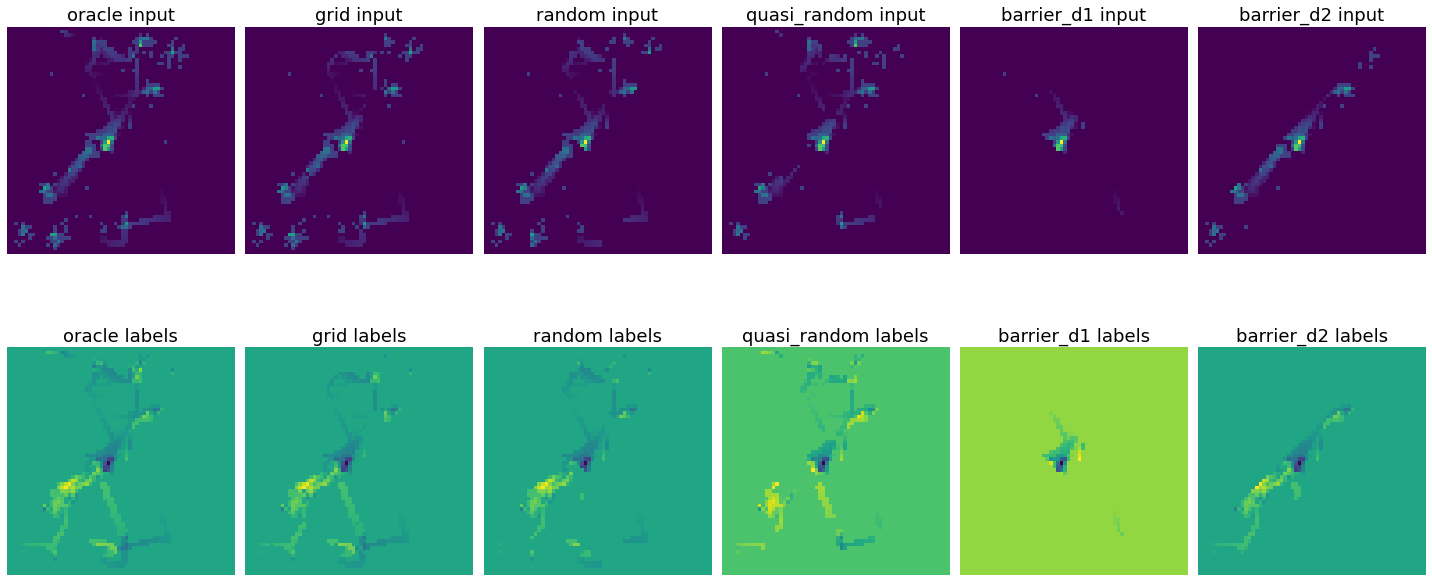

In [74]:
generate_sensor_comparison_plots(next_window_test, sensor_kwargs, seed=15, save_name='Next-Window-Sensor-Plots.pdf')